# AOPC

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle
def acquire(x):
    dicts = {}
    files = []
    file_path = "dati/mean_trained/"
    data = ["initial_conf", "conf_tot", "iou_tot"]
    for i in range(len(data)):
        files.append(file_path + "0" + str(x) + "_" + str(data[i]) + ".pkl")
    for i,file in enumerate(files):
        with open(file, 'rb') as dict:
            loaded_dict = pickle.load(dict)
            dicts[data[i]] = loaded_dict
    return dicts
def remove_none(dict):
    sub_dict = dict["initial_conf"]
    for key in sub_dict:
        if sub_dict[key] is None:
            sub_dict[key] = 0
    return sub_dict
def plot_dict(dict, cls):
    correct_dict = remove_none(dict)
    keys = range(len(list(correct_dict.keys())))
    values = list(correct_dict.values())
    plt.figure(figsize=(15, 10)) 

    plt.bar(keys, values)
    plt.xlabel('Keys')
    plt.ylabel('Confidence')
    plt.title('Confidence level for each image ' + cls)
    plt.show()
def sum_norm(dict):
    sum_values = []
    for index in range(len(next(iter(dict.values())))):
        index_sum = 0

        for key, value_list in dict.items():
            index_sum += value_list[index]
    
        sum_values.append(index_sum)
    min_value = min(sum_values)
    max_value = max(sum_values)

    normalized_values = [(x - min_value) / (max_value - min_value) for x in sum_values]
    return normalized_values
def plot(dict, cls, flag):
    step = []
    conf = sum_norm(dict["conf_tot"])
    iou = sum_norm(dict["iou_tot"])
    baseline = baseline_conf(dict)
    for i in range(0, 101, 5):
        step.append(i)
    if flag:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7)) 
        ax1.plot(step, conf, label= "Confidence", marker='o', linestyle='-')
        ax1.axhline(y=baseline, color='r', linestyle='--', label='Baseline')
        ax1.legend()
        ax1.grid(True)
        ax1.set_title("Confidence " + cls)
        ax2.plot(step, iou, label= "IoU",marker='o', linestyle='-')
        ax2.set_title("IoU " + cls)
        ax2.grid(True)
    else:
        plt.figure(figsize=(15, 10))  
        plt.plot(step, conf, label= "Confidence", marker='o', linestyle='-')
        plt.axhline(y=baseline, color='r', linestyle='--', label='Baseline')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()
def find_min(dict):
    dict_correct = remove_none(dict)
    filtered_values = [value for value in dict_correct.values() if value != 0]
    if filtered_values:
        min_value = min(filtered_values)
        return [key for key, value in dict_correct.items() if value == min_value]
def sort_remove(dict):
    dict_correct = remove_none(dict)
    return {k: v for k, v in sorted(dict_correct.items(), key=lambda item: item[1]) if v != 0}
def plot_example(dict, ex):
    example_inital = dict["initial_conf"][ex]
    example = dict["conf_tot"][ex]
    for i in range(len(example)):
        if example[i] == -1:
            example[i] = 0
    conf_tot = [x - example_inital for x in example]
    steps = []
    for i in range(0, 101, 5):
        steps.append(i)
    plt.plot(steps, example, label = "Modified", marker='o', linestyle='-')
    plt.axhline(y=example_inital, color='r', linestyle='--', label='Baseline')
    print("Area Over the Perturbation Curve",sum(example) / len(steps))
    plt.legend()
    plt.xlabel('Pixel perturbation')
    plt.ylabel('Confidence')
    plt.title('Confidence vs. Pixel perturbation')
    plt.grid(True) 
    plt.show()
def baseline_conf(dict):
    dict_correct = remove_none(dict)
    return sum(dict_correct.values()) / len(dict_correct)

In [105]:
import random

def replacepixel(img, mask, percentile_value, task):
    mask = mask *255
    mask = mask.astype(np.uint8)
    image = Image.fromarray(img)
    mask = Image.fromarray(mask)
    # percentile_value = 100 - percentile_value
    mask_intensity = np.percentile(mask, percentile_value)
    # Get pixel access objects
    pixel_data = image.load()
    mask_data = mask.load()
    pixel_data = image.load()
    mask_data = mask.load()
    modified_mask = mask.copy()
    modified_mask_data = modified_mask.load()
    width, height = image.size
    mask_intensity_values = [(mask_r + mask_g + mask_b) / 3 for mask_r, mask_g, mask_b in mask.getdata()]
    if (task == 'mean'):
        mean_r = np.mean(img[:, :, 0])
        mean_g = np.mean(img[:, :, 1])
        mean_b = np.mean(img[:, :, 2])
    for x in range(width):
        for y in range(height):
            mask_intensity_value = mask_intensity_values[y * width + x]

            if mask_intensity_value <= mask_intensity:
                if(task == 'random'):
                    new_r = random.randint(0, 255)
                    new_g = random.randint(0, 255)
                    new_b = random.randint(0, 255)
                    modified_mask_data[x, y] = (new_r, new_g, new_b)
                    pixel_data[x, y] = (new_r, new_g, new_b) #random
                elif(task == 'mean'):
                    pixel_data[x, y] = (int(mean_r), int(mean_g), int(mean_b)) #mean
                elif(task == "remove"):
                    r, g, b = pixel_data[x, y]
                    mask_r, mask_g, mask_b = mask_data[x, y]
                    
                    new_r = r * (mask_r / 255) 
                    new_g = g * (mask_g / 255)  
                    new_b = b * (mask_b / 255)  
                    modified_mask_data[x, y] = (int(new_r), int(new_g), int(new_b))
                    pixel_data[x, y] = (int(new_r), int(new_g), int(new_b))

    # Convert the modified Pillow Image back to a numpy array
    modified_image = np.array(image)
    modified_mask = np.array(modified_mask)
    return modified_image, modified_mask

def perturbation(img, mask, percentile, task, bbox, cls):
    results = model(img, verbose=False, max_det=1)
    boxes = results[0].boxes
    original = results[0].plot()
    conf = float(boxes.conf.cpu().numpy())
    # data = results[0].boxes.data.cpu().numpy()
    # print(data)
    if(task == "remove"):
        perturbed = img * mask
        #perturbed, _ = replacepixel(img, mask, percentile, task)
    if(task == "mean"):
        perturbed, _ = replacepixel(img, mask, percentile, task)
    if(task == "random"):
        perturbed, _ = replacepixel(img, mask, percentile, task)
    results = model([perturbed], max_det=1, classes = cls)
    if len(results[0].boxes) != 0:
        iou = calculate_iou(bbox,results[0].boxes.xyxy[0].cpu().numpy())
        # data = results[0].boxes.data.cpu().numpy()
        # print(data)
        new = results[0].plot()
        boxes = results[0].boxes
        conf_incr =  float(boxes.conf.cpu().numpy()) - conf
        out = np.stack((original, new), axis=0) 
        return out, conf_incr, iou
    else:
        return None, None, None
    
def invert_grayscale_image(image):
    # Calculate the maximum pixel value for the grayscale image (usually 255 for 8-bit images)
    max_pixel_value = np.max(image)
    
    # Invert the image by subtracting each pixel value from the maximum
    inverted_image = max_pixel_value - image
    
    return inverted_image

In [ ]:
cls_1 = acquire(1)
plot(cls_1, "Class 1", False)

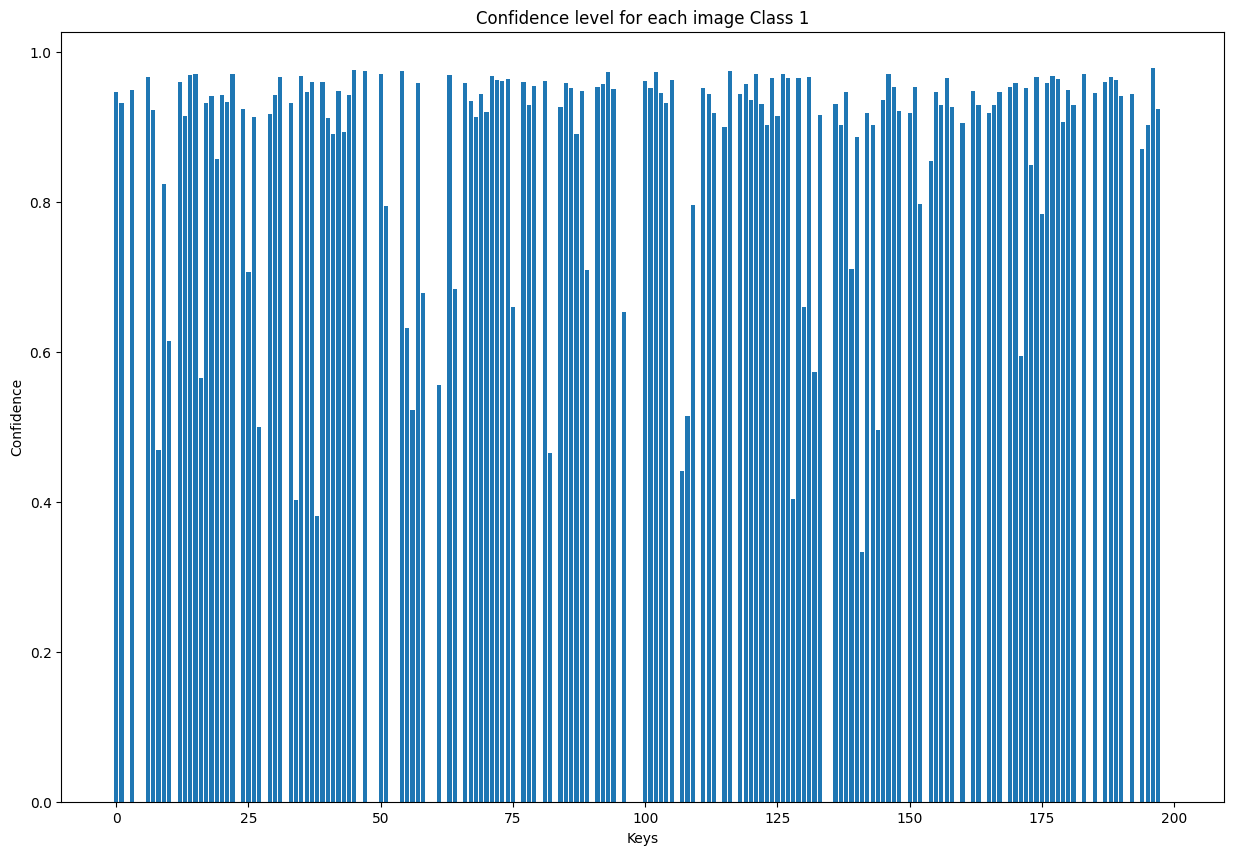

In [116]:
plot_dict(cls_1, "Class 1")

In [126]:
if not cls_1["conf_tot"]['28-05-2023_19-16-00_Cam2_164.jpg']:
    print("hello")

hello


In [129]:
dict = cls_1["conf_tot"]
not_valid = 0

for index in range(len(next(iter(dict.values())))):
    index_sum = 0

    for key, value_list in dict.items():
        if not dict[key]:
            not_valid +=1
        else:
            print(value_list[index

-1
0.9320500493049622
-1
0.9656769633293152
0.9196051955223083
-1
0.8177641034126282
-1
0.9591783285140991
0.9088239073753357
0.9688827395439148
-1
0.3192974328994751
0.5504084229469299
0.9408876299858093
0.8578727841377258
0.9417979121208191
0.9288906455039978
0.9693151116371155
0.9242402911186218
0.7560780644416809
0.9139239192008972
-1
0.9160538911819458
0.9415205121040344
0.9574792385101318
0.9262920022010803
-1
-1
-1
0.9579967856407166
-1
0.95908522605896
0.9113849997520447
-1
-1
0.8942534327507019
-1
-1
-1
0.969708263874054
0.7022599577903748
-1
-1
0.5055171251296997
0.9585013389587402
0.6873461008071899
0.5630145072937012
0.9325056076049805
0.5543121695518494
0.9570889472961426
-1
-1
-1
-1
0.9684259295463562
0.9622254967689514
0.9604867696762085
0.9631623029708862
-1
0.9593295454978943
0.9276472926139832
-1
0.9453052878379822
-1
0.9179584383964539
-1
-1
0.8885388374328613
0.9483081698417664
0.6799346208572388
0.954177737236023
-1
-1
0.7671725749969482
0.6283721923828125
0.959744

In [101]:
cls_1["conf_tot"]

{'14-05-2023_10-13-16_Cam4_573.jpg': [0.9671006798744202,
  0.9671006798744202,
  0.9671006798744202,
  0.9671006798744202,
  0.9671006798744202,
  0.9671006798744202,
  0.9671006798744202,
  0.9671006798744202,
  0.9671006798744202,
  0.9671006798744202,
  0.9671006798744202,
  0.966843843460083,
  0.9670160412788391,
  0.9669737815856934,
  0.9668485522270203,
  0.9657183289527893,
  0.9661624431610107,
  0.9664130210876465,
  0.8836284279823303,
  -1,
  -1],
 '28-05-2023_19-16-00_Cam3_1248.jpg': [-1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1],
 '28-05-2023_19-16-00_Cam1_649.jpg': [-1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1],
 '28-05-2023_19-16-00_Cam4_2189.jpg': [0.9356162548065186,
  0.9356162548065186,
  0.9356162548065186,
  0.9356162548065186,
  0.9356162548065186,
  0.9356162548065186,
  0.9356162548065186,
  0.935616254806

In [95]:
plot(cls_1, "Class 1", False)

IndexError: list index out of range

In [93]:
for i in range(6):
    cls = acquire(i)
    plot_dict(cls, "Class " + str(i))
    plot(cls, "Class " + str(i), True)

FileNotFoundError: [Errno 2] No such file or directory: 'dati/mean_trained/00_initial_conf.pkl'

## Esempio Singola Immagine

In [65]:
dict = acquire(1)
average = baseline_conf(dict)

In [67]:
sort_remove(dict)

{'20-04-2023_11-11-57_Cam1_173.jpg': 0.2536807656288147,
 '26-05-2023_16-04-04_Cam2_692.jpg': 0.2621783912181854,
 '29-04-2023_12-07-36_Cam2_184.jpg': 0.28429707884788513,
 '08-05-2023_09-46-54_Cam2_536.jpg': 0.4299241304397583,
 '20-04-2023_11-11-57_Cam2_76.jpg': 0.480192095041275,
 '08-05-2023_09-46-54_Cam2_327.jpg': 0.5561591386795044,
 '29-05-2023_11-16-29_Cam2_769.jpg': 0.6206823587417603,
 '19-05-2023_20-39-59_Cam1_115.jpg': 0.6367163062095642,
 '19-05-2023_20-39-59_Cam2_135.jpg': 0.6821815371513367,
 '04-05-2023_14-00-56_Cam1_1020.jpg': 0.7064106464385986,
 '26-05-2023_16-04-04_Cam4_2.jpg': 0.7084938287734985,
 '29-05-2023_11-16-29_Cam2_633.jpg': 0.723855197429657,
 '08-05-2023_09-46-54_Cam3_621.jpg': 0.7952417731285095,
 '19-05-2023_20-39-59_Cam2_330.jpg': 0.795387864112854,
 '29-05-2023_11-16-29_Cam2_434.jpg': 0.7969698309898376,
 '29-04-2023_12-07-36_Cam2_63.jpg': 0.8093493580818176,
 '19-05-2023_20-39-59_Cam1_142.jpg': 0.8109235763549805,
 '19-05-2023_20-39-59_Cam2_168.jpg':

In [68]:
find_min(dict)

['20-04-2023_11-11-57_Cam1_173.jpg']

Area Over the Perturbation Curve 0.690535945551736


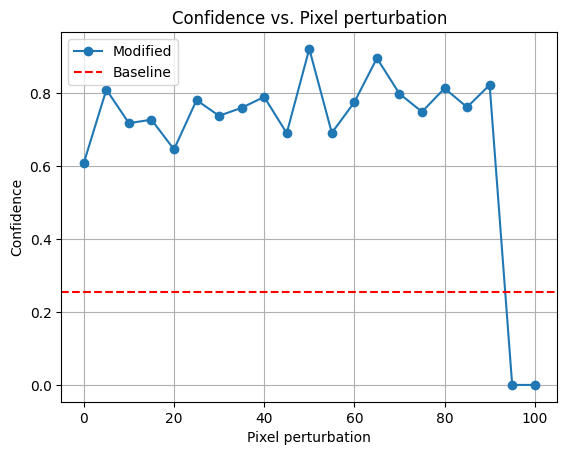

In [70]:
plot_example(dict,'20-04-2023_11-11-57_Cam1_173.jpg')

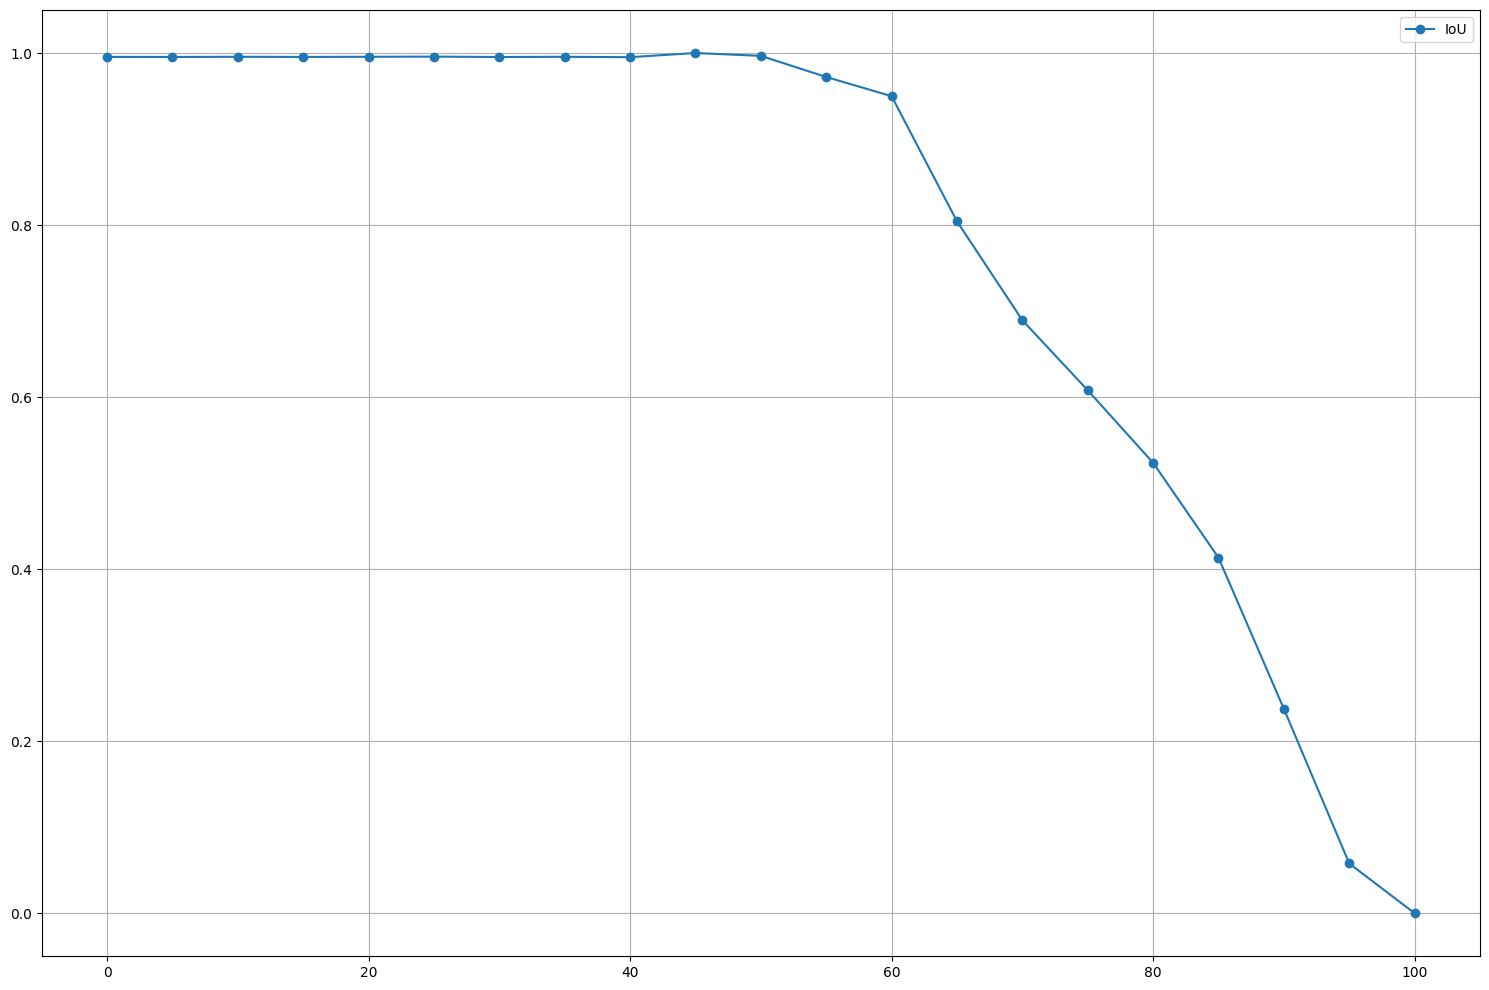

In [84]:
step = []

iou = sum_norm(dict["iou_tot"])
for i in range(0, 101, 5):
    step.append(i)
plt.figure(figsize=(15, 10))  
plt.plot(step, iou, label= "IoU",marker='o', linestyle='-')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
image_path = "utils/dataset/subset/01_SpeedBoat/20-04-2023_11-11-57_Cam1_173.jpg"


0: 640x640 1 Speed Boat, 60.6ms
Speed: 4.2ms preprocess, 60.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


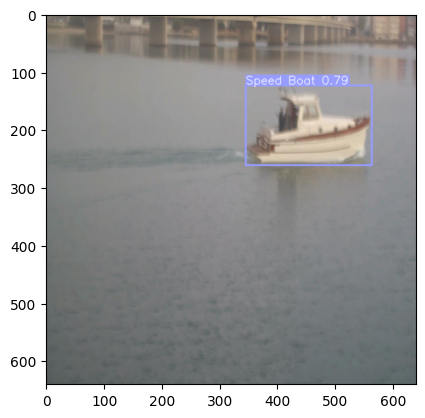

In [75]:
import cv2
from PIL import Image
from ultralytics import YOLO
img = np.array(Image.open(image_path))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = img.astype(np.float32) / 255.0
model = YOLO("models/VisibleModel/weights/best.pt")
COLORS = np.random.uniform(0, 255, size=(len(model.names), 3))
results = model(rgb_img, verbose=True, classes=1)
plt.imshow(results[0].plot())



0: 640x640 1 Speed Boat, 59.6ms
Speed: 4.2ms preprocess, 59.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


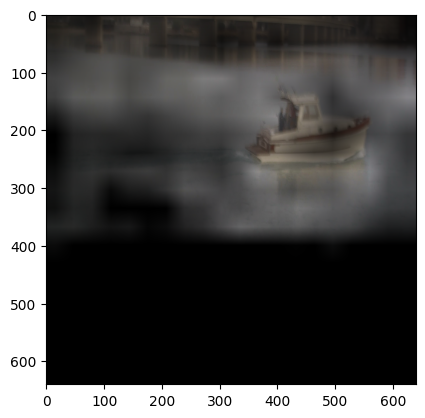

In [76]:
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

target_layers = [model.model.model[-3]]
cam = EigenCAM(model, target_layers)
grayscale_cam = cam(rgb_img)[0, :, :]
g_scale = np.stack([grayscale_cam] * 3, axis=2)
plt.imshow(g_scale/255*rgb_img)



0: 640x640 1 Speed Boat, 56.5ms
Speed: 9.5ms preprocess, 56.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


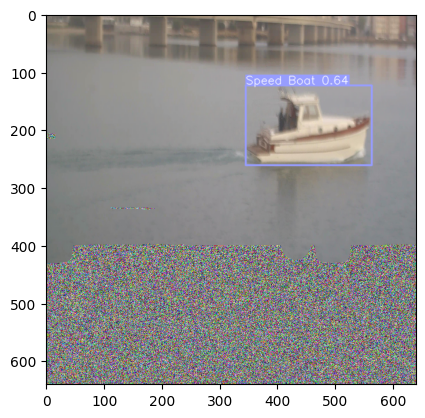


0: 640x640 1 Speed Boat, 88.6ms
Speed: 4.4ms preprocess, 88.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


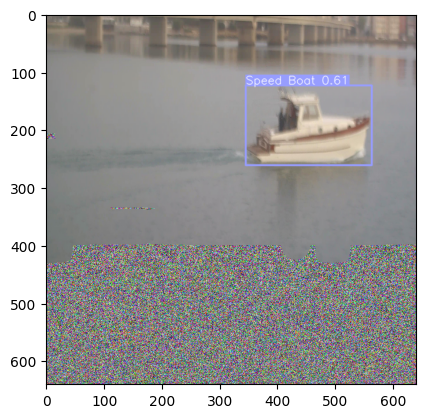


0: 640x640 1 Speed Boat, 56.3ms
Speed: 3.7ms preprocess, 56.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


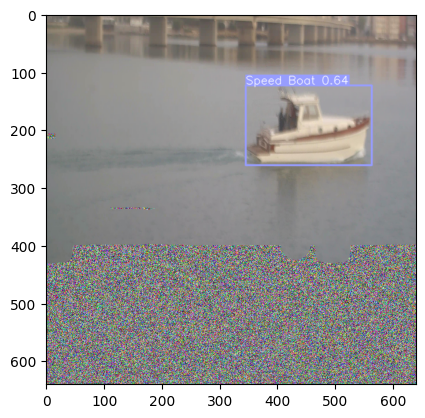


0: 640x640 1 Speed Boat, 69.5ms
Speed: 3.8ms preprocess, 69.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


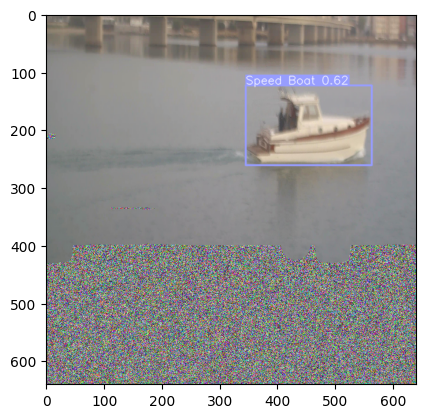


0: 640x640 1 Speed Boat, 56.1ms
Speed: 3.1ms preprocess, 56.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


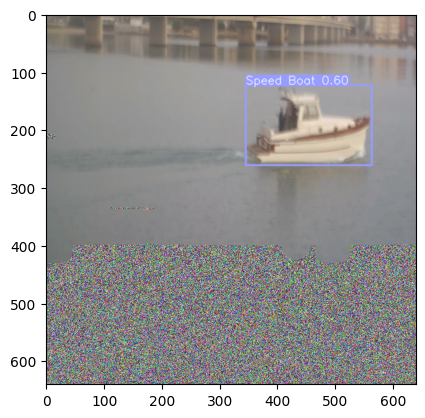


0: 640x640 1 Speed Boat, 56.7ms
Speed: 3.5ms preprocess, 56.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


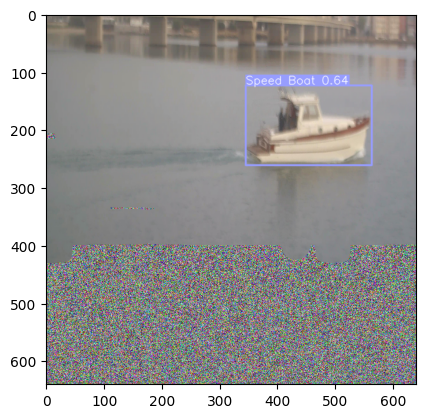


0: 640x640 1 Speed Boat, 56.6ms
Speed: 3.4ms preprocess, 56.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


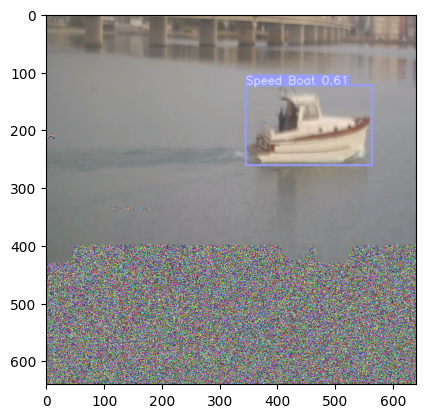


0: 640x640 1 Speed Boat, 56.4ms
Speed: 3.4ms preprocess, 56.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


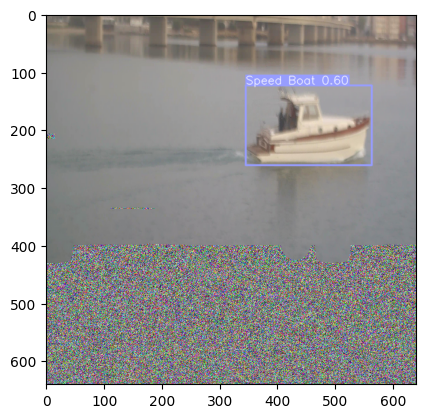


0: 640x640 1 Speed Boat, 55.8ms
Speed: 3.3ms preprocess, 55.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


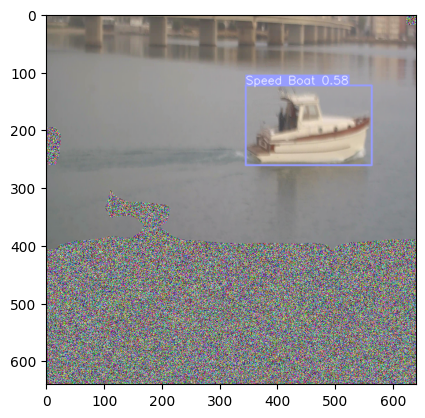


0: 640x640 1 Speed Boat, 56.3ms
Speed: 3.3ms preprocess, 56.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


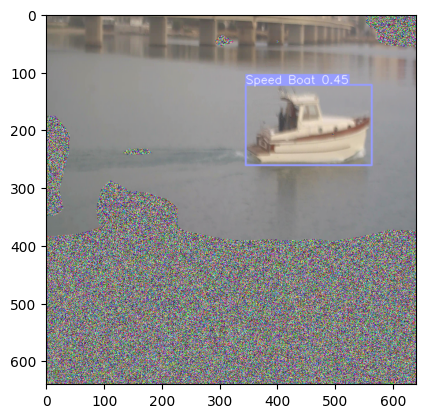


0: 640x640 (no detections), 56.3ms
Speed: 3.5ms preprocess, 56.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


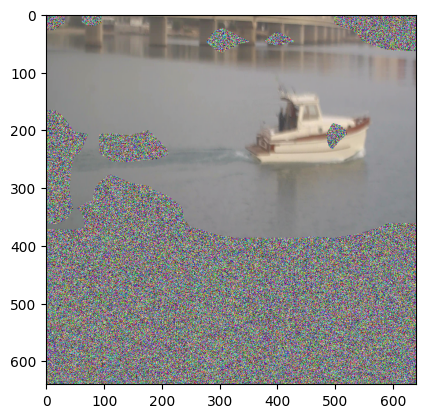


0: 640x640 (no detections), 56.8ms
Speed: 3.2ms preprocess, 56.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


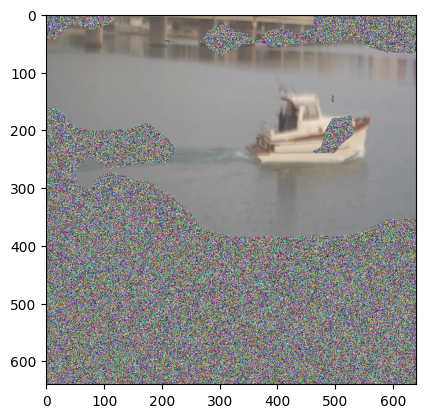


0: 640x640 (no detections), 62.7ms
Speed: 3.5ms preprocess, 62.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


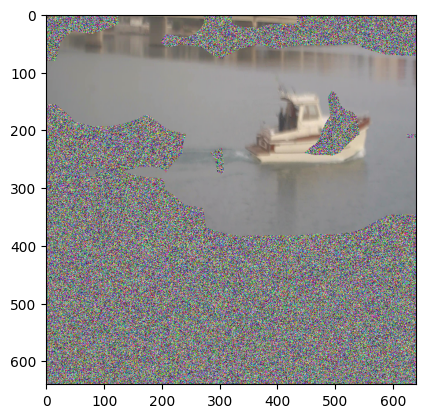


0: 640x640 (no detections), 56.4ms
Speed: 3.3ms preprocess, 56.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


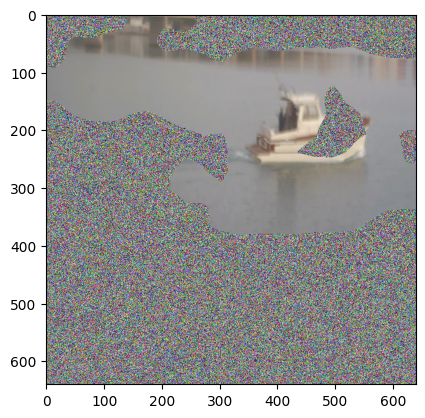


0: 640x640 (no detections), 56.1ms
Speed: 3.6ms preprocess, 56.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


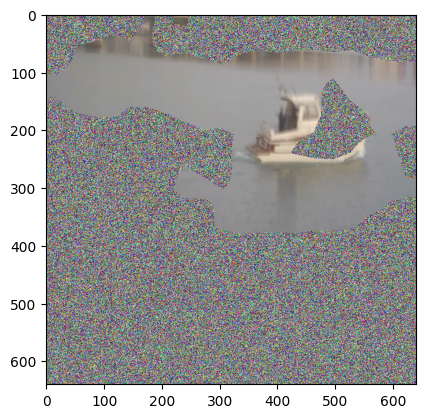


0: 640x640 (no detections), 56.7ms
Speed: 3.9ms preprocess, 56.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


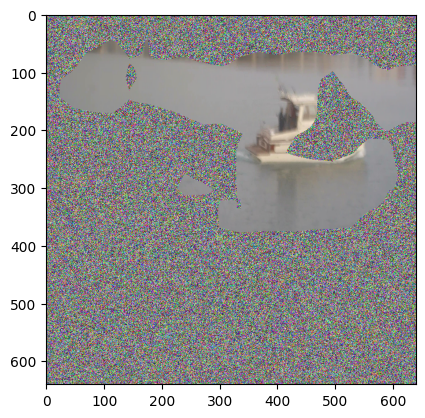


0: 640x640 (no detections), 55.9ms
Speed: 3.7ms preprocess, 55.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


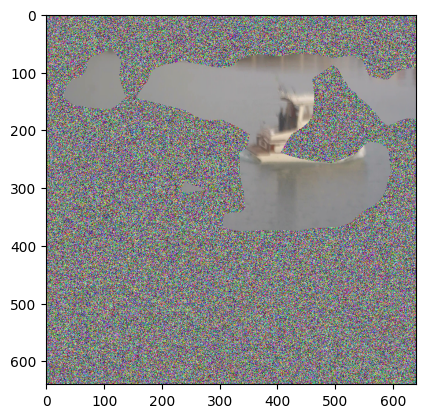


0: 640x640 (no detections), 58.4ms
Speed: 3.9ms preprocess, 58.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


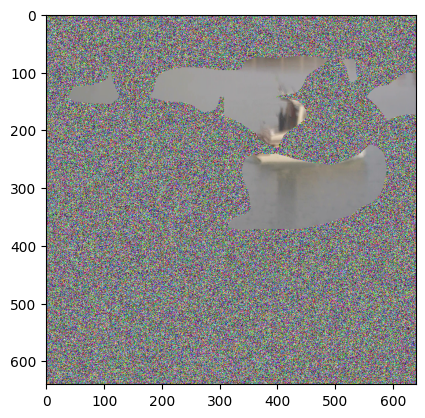


0: 640x640 (no detections), 75.1ms
Speed: 3.4ms preprocess, 75.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


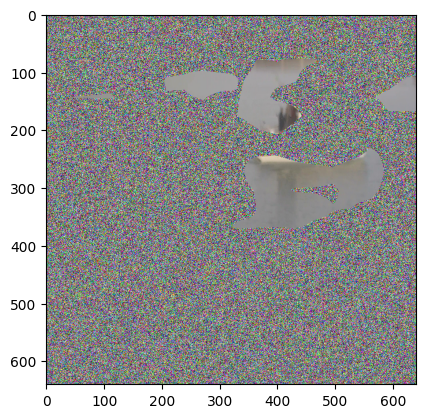


0: 640x640 (no detections), 56.3ms
Speed: 3.5ms preprocess, 56.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


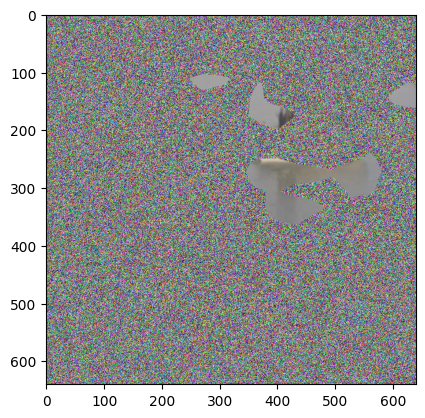


0: 640x640 (no detections), 56.1ms
Speed: 4.8ms preprocess, 56.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


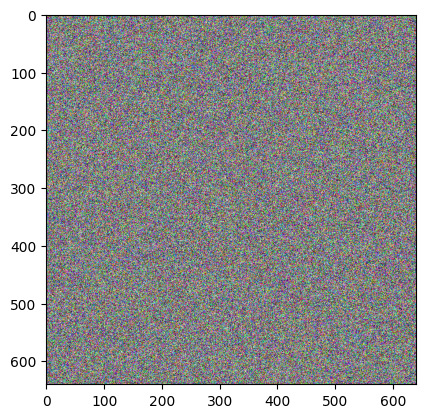

In [81]:
for i in range (0,101,5):    
    perturbed, _ = replacepixel(rgb_img, g_scale, i, "random")
    results = model(perturbed, verbose=True, classes=1, max_det=1)
    plt.imshow(results[0].plot())
    plt.show()

# HAAS